In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("C:\\Users\\Xiaochen\\Desktop\\Project\\Subscription\\subscription.csv")

In [3]:
data.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


In [4]:
# Check if the relationship is linear by using a graph
#firstly get count by billing cycle and price point
retention_rate_data_points = data.groupby(['subscription_monthly_cost', 'billing_cycles']).size().reset_index(name = 'tmp_count_billing')

In [5]:
retention_rate_data_points

,subscription_monthly_cost,billing_cycles,tmp_count_billing
0,29,1,57441
1,29,2,21818
2,29,3,12037
3,29,4,7787
4,29,5,5505
5,29,6,4136
6,29,7,3111
7,29,8,34527
8,49,1,185145
9,49,2,53296


In [6]:
#then estimate retention rate: cumulative sum by billing cycle divided by total users gives churn rate
#i.e. 1 - churn_rate is actual retention rate
retention_rate_data_points['retention_rate'] = retention_rate_data_points.groupby('subscription_monthly_cost')['tmp_count_billing'].transform(
                                               lambda x: 1-x.cumsum()/x.sum()
                                               )

In [8]:
retention_rate_data_points

,subscription_monthly_cost,billing_cycles,tmp_count_billing,retention_rate
0,29,1,57441,0.607542
1,29,2,21818,0.458473
2,29,3,12037,0.376232
3,29,4,7787,0.323028
4,29,5,5505,0.285416
5,29,6,4136,0.257157
6,29,7,3111,0.235901
7,29,8,34527,0.000000
8,49,1,185145,0.383666
9,49,2,53296,0.206247


In [9]:
# remove tmp_count_billing column and billing cycle == 8 because those are still active
retention_rate_data_points = retention_rate_data_points.drop('tmp_count_billing', 1).query('billing_cycles < 8')

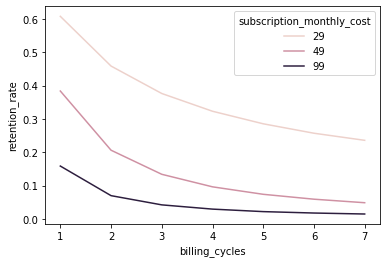

In [10]:
# Plot the graph
sns.lineplot(x="billing_cycles", y="retention_rate", 
             hue="subscription_monthly_cost", data=retention_rate_data_points, legend="full"
             )
plt.show()

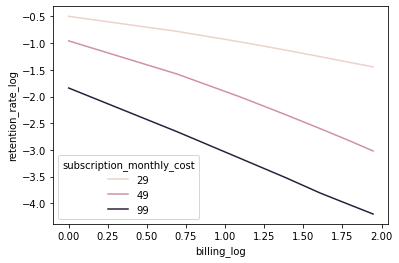

In [11]:
# The relationship is non-linear. We need to use log to transform it to a linear relationship
retention_rate_data_points["billing_log"] = np.log(retention_rate_data_points["billing_cycles"])

retention_rate_data_points["retention_rate_log"] = np.log(retention_rate_data_points["retention_rate"])

#plot 
sns.lineplot(x="billing_log", y="retention_rate_log", 
             hue="subscription_monthly_cost", data=retention_rate_data_points, legend="full"
             )
plt.show()

### Build the model

In [12]:
import statsmodels.api as sm

In [13]:
#build linear model for price 29
y29 = retention_rate_data_points.query('subscription_monthly_cost==29')['retention_rate_log']
X29 = retention_rate_data_points.query('subscription_monthly_cost==29')['billing_log']
X29 = sm.add_constant(X29)

In [14]:
model29 = sm.OLS(y29, X29)
results29 = model29.fit()
print("R Squared for $29 is:", round(results29.rsquared,2))

R Squared for $29 is: 0.99


In [16]:
#build linear model for price 49
y49 = retention_rate_data_points.query('subscription_monthly_cost==49')['retention_rate_log']
X49 = retention_rate_data_points.query('subscription_monthly_cost==49')['billing_log']
X49 = sm.add_constant(X49)
  
model49 = sm.OLS(y49, X49)
results49 = model49.fit()
print("R Squared for $49 is:", round(results49.rsquared,2))

R Squared for $49 is: 1.0


In [17]:
#build linear model for price 99
y99 = retention_rate_data_points.query('subscription_monthly_cost==99')['retention_rate_log']
X99 = retention_rate_data_points.query('subscription_monthly_cost==99')['billing_log']
X99 = sm.add_constant(X99)
  
model99 = sm.OLS(y99, X99)
results99 = model99.fit()
print("R Squared for $99 is:", round(results99.rsquared,2))

R Squared for $99 is: 1.0


### Make the predictions for percentage of users is still subscribed after at least 12 months for each price point

In [18]:
#make the predictions
Xpred = np.log(range(8,13))
Xpred = sm.add_constant(Xpred)
print(results29.predict(Xpred))

[-1.48549968 -1.54324007 -1.5948906  -1.64161419 -1.68426949]


In [19]:
# take the exponential of those predictions
print(np.exp(results29.predict(Xpred)))

[0.22638919 0.21368762 0.20293073 0.19366717 0.18557995]


In [20]:
print("For the $29 price point, after 1 year, we will retain", 
      round(np.exp(results29.predict(Xpred))[4], 3), 
     "of our customers")

For the $29 price point, after 1 year, we will retain 0.186 of our customers


In [21]:
print("For the $49 price point, after 1 year, we will retain", 
      round(np.exp(results49.predict(Xpred))[4], 3), 
     "of our customers")

For the $49 price point, after 1 year, we will retain 0.029 of our customers


In [22]:
print("For the $99 price point, after 1 year, we will retain", 
      round(np.exp(results99.predict(Xpred))[4], 3), 
     "of our customers")

For the $99 price point, after 1 year, we will retain 0.008 of our customers


### Calculate the customer LTV

In [25]:
#The models work well enough that we can directly use their predictions for all 12 billing cycle to estimate customer LTV.
  
Xpred = np.log(range(1,13))
Xpred = sm.add_constant(Xpred)
#Firstly get retention rate for each billing cycle
retention_rate_tmp = np.exp(results29.predict(Xpred))
retention_rate_tmp

array([0.62744329, 0.44668519, 0.36616507, 0.3180011 , 0.2850498 ,
       0.26067776, 0.24170458, 0.22638919, 0.21368762, 0.20293073,
       0.19366717, 0.18557995])

In [26]:
#Then get overall expected value by multiplying each probability * corresponding money at each billing cycle.
LTV_29 = 29 + sum(retention_rate_tmp * 29)
print("Avg LTV of customers paying $29 a month is:", round(LTV_29), "dollars")

Avg LTV of customers paying $29 a month is: 132 dollars


In [27]:
retention_rate_tmp = np.exp(results49.predict(Xpred))
LTV_49 = 49 + sum(retention_rate_tmp * 49)
print("Avg LTV of customers paying $49 a month is:", round(LTV_49), "dollars")

Avg LTV of customers paying $49 a month is: 107 dollars


In [28]:
retention_rate_tmp = np.exp(results99.predict(Xpred))
LTV_99 = 99 + sum(retention_rate_tmp * 99)
print("Avg LTV of customers paying $99 a month is:", round(LTV_99), "dollars")

Avg LTV of customers paying $99 a month is: 139 dollars


#### Insights
- 99 price point has the highest LTV
- Considering 29 price point has a much higher 1-year retention rate, if we have a larger window to define the LTV, 29 will likely to have the best one

### Check if country and source affect the retention rate

In [29]:
#group by country and price and check retention rate as defined above
country_retention = data.groupby(['country', 'subscription_monthly_cost']).apply(
                    lambda x: pd.Series({
                             # active users
                            'retention_rate': x['is_active'].mean(),
                             # total count by price and country
                            'count': x['is_active'].count(),
                            # avg revenue by price and country
                            'revenue' : (x['subscription_monthly_cost'] * x['billing_cycles']).mean()
  })
).reset_index()
country_retention

,country,subscription_monthly_cost,retention_rate,count,revenue
0,China,29,0.611194,16741.0,168.266173
1,China,49,0.020603,18541.0,77.103446
2,China,99,0.006098,656.0,119.373476
3,France,29,0.132290,14249.0,84.166959
4,France,49,0.020660,31074.0,77.692927
5,France,99,0.006310,6339.0,116.132513
6,Germany,29,0.125172,21794.0,83.057309
7,Germany,49,0.071946,55500.0,115.050234
8,Germany,99,0.022146,11650.0,145.636223
9,India,29,0.605556,16920.0,167.610402


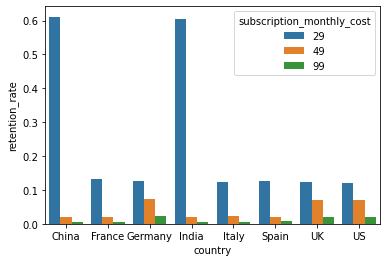

In [30]:
# Plot retention rate by country and price
sns.barplot(x="country", hue="subscription_monthly_cost", y="retention_rate", data=country_retention)
plt.show()

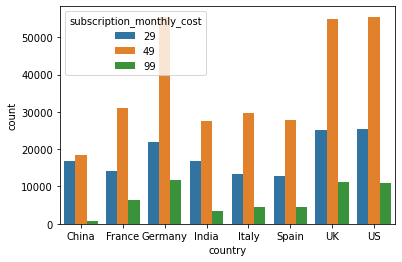

In [31]:
# Plot user count by country and price
sns.barplot(x="country", hue="subscription_monthly_cost", y="count", data=country_retention)
plt.show()

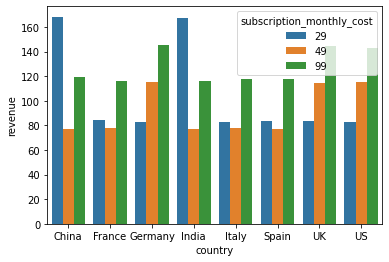

In [32]:
# Avg user revenue for each country within the first 8 months
sns.barplot(x="country", hue="subscription_monthly_cost", y="revenue", data=country_retention)
plt.show()

#### Insights
- China and India have much higher retention rate at the \\$29 price point. There are more price- sensetive users in these two countries
- When looking at the user revenue, the best price point for China and India is \\$29, but the best price point for the other countries is $99. But all countries have the most users for the middile price
- If we could shift users towards the optimal price point, this would increase user LTV, and that would have several positive effects, beside the obvious revenue gain. For instance, higher LTV means that we could bid higher for ads, and therefore grow much faster
- The goal is essentially to make given price points more attractive on a country basis. A way to achieve this would be to change the UI so that, for each country, the optimal price point is more prominent.
Another approach could be to look into how users from each country are using the product. Figure out what they like the most and then play around with each price point features in such a way that the best price has the most attractive features for each country.
Another approach could be targeted/regional coupons

### Check if country and source affect the retention rate

In [33]:
# group by source and price and check retention rate as defined above
source_retention = data.groupby(['source', 'subscription_monthly_cost']).apply(
                    lambda x: pd.Series({
                             # active users
                            'retention_rate': x['is_active'].mean(),
                             # total count by price and source
                            'count': x['is_active'].count(),
                            # avg revenue by price and source
                            'revenue' : (x['subscription_monthly_cost'] * x['billing_cycles']).mean()
  })
).reset_index()
      
source_retention

,source,subscription_monthly_cost,retention_rate,count,revenue
0,ads,29,0.191041,121246.0,94.460840
1,ads,49,0.016791,249177.0,84.071861
2,ads,99,0.002407,44046.0,120.366163
3,friend_referral,29,0.618289,7097.0,168.818656
4,friend_referral,49,0.399548,14589.0,228.250188
5,friend_referral,99,0.162655,2742.0,273.062363
6,seo,29,0.387147,18019.0,132.655808
7,seo,49,0.127215,36631.0,141.973056
8,seo,99,0.038277,6453.0,170.001395


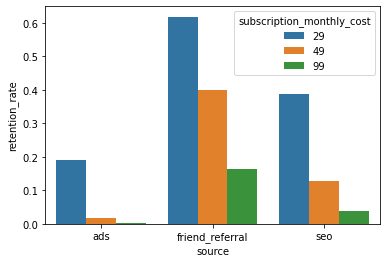

In [34]:
# Plot retention rate by source and price
sns.barplot(x="source", hue="subscription_monthly_cost", y="retention_rate", data=source_retention)
plt.show()

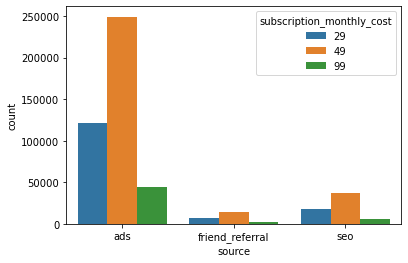

In [35]:
# Plot user count by source and price
sns.barplot(x="source", hue="subscription_monthly_cost", y="count", data=source_retention)
plt.show()

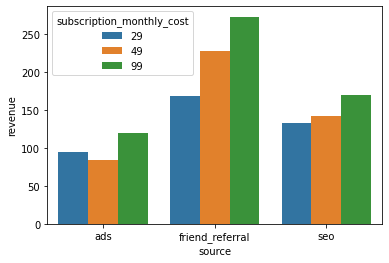

In [36]:
# Avg user revenue for each source within the first 8 months
sns.barplot(x="source", hue="subscription_monthly_cost", y="revenue", data=source_retention)
plt.show()

#### Insights
- The high majority of users is coming from ads. Unfortunately, these users have the lowest retention and, consequently, the lowest LTV. Even worse, those ads are mainly attracting \\$49 customers. That’s highly inefficient. Ads campaigns should be optimized to attract customers with higher likelihood of buying the optimal price point
- Friend referral is doing really well, but has very low absolute numbers. Increasing this is a big opportunity. And the discount that is usually given to referred users can also be used as a leverage for the price discussion from above
- SEO is also doing better than ads in terms of retention, but there are way less users. This is also a big opportunity, especially because SEO is the only one that doesn’t cost anything